# Синтез изображений. Часть 2. Генеративно-Состязательная Сеть (GAN)

## Переключение версии TensorFlow

In [1]:
# %tensorflow_version 2.x

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.version.VERSION)

In [ ]:
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
tf.config.get_visible_devices('GPU')

## Загрузка и подготовка датасета MNIST

## Загрузка датасета LFW

In [4]:
ds, ds_info = tfds.load('lfw', 
                        split='train', 
                        shuffle_files=True,
                        with_info=True,
                       )

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
test = ds.take(1)
for example in test:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  label = label.numpy().decode('utf-8')
  print(image.shape, label)

['image', 'label']
(250, 250, 3) Kimi_Raikkonen


In [7]:
train_ds = ds

## Визуализация датасета LFW

In [ ]:
import matplotlib

def plot_faces(samples):   
    fig = plt.figure(figsize=(18, 12))

    for j, image in enumerate(samples):
        ax = fig.add_subplot(4, 6, j+1)
        image = image/2.+1.
        print(np.min(image), np.max(image))
#         ax.imshow(image, norm=matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False))
        ax.imshow(image, vmin=-1, vmax=1)
        plt.xticks([]), plt.yticks([])
    plt.show()

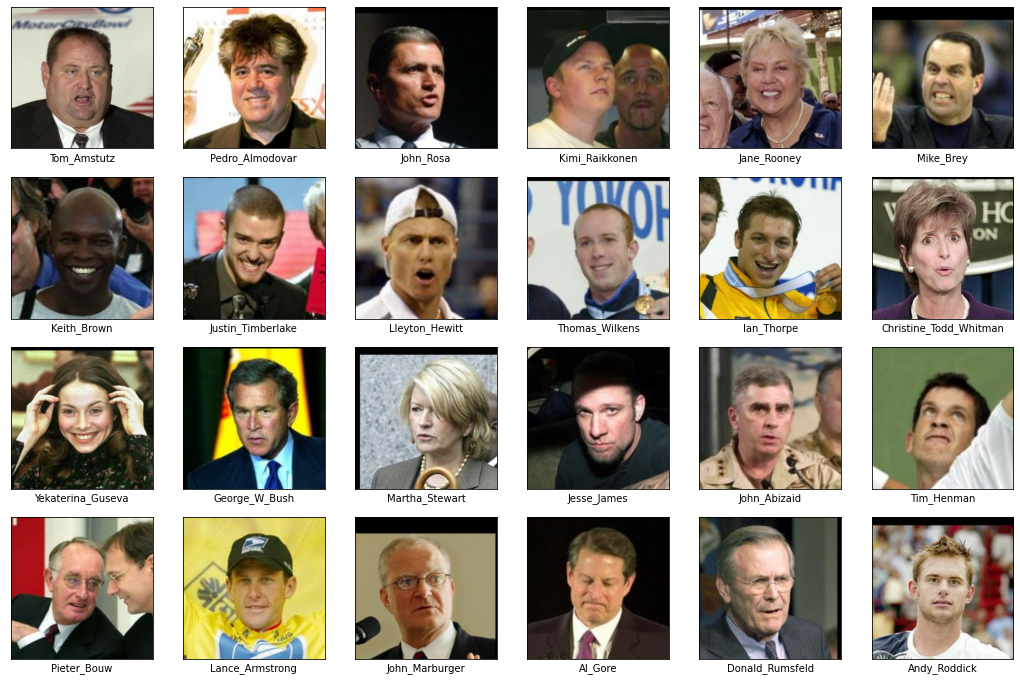

In [9]:
examples = train_ds.take(24)

fig = plt.figure(figsize=(18, 12))

for j, example in enumerate(examples):
    image, label = example["image"],  example["label"]
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(image)
    label = label.numpy().decode("utf-8")
    ax.set_xlabel(label)
    plt.xticks([]), plt.yticks([])
plt.show()


## Подготовка пайплайна данных и оптимизатора

In [10]:
INPUT_DIM = 100
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002


In [11]:
def img_prep(img):
    # приведем к масштабируемому формату
    img = tf.image.resize(img, [240, 240],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.cast(img, tf.float32)/127.5-1.
#     img = tf.cast(img, tf.float32)/255.
    return img

def prepare(img):
    img['image'] = img_prep(img['image'])
    return img

In [12]:
train_ds = ds

train_ds = train_ds.map(prepare)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Deep Convolutional GAN (DCGAN)

In [13]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*30*30, activation='relu'),
    tf.keras.layers.Reshape((30, 30, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2), 
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [14]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
for step, images in enumerate(train_ds):
    
#     print(train_ds.element_spec)
    true_images = images['image']
#     print(true_images.shape)
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
#     print(syntetic_images.shape)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 100 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images)


In [ ]:
tf.get_logger().setLevel(logging.DEBUG)

## Тестирование свёрточного генератора

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)